In [1]:
import os
os.chdir('/home/golopes/mestrado/projetos/FoodAid/')

import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm', disable=['lemmatizer', 'tagger', 'ner'])
from ingredient_parser import ingredient_parser
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pattern.text.en import singularize
import keras

def get_labels(df, tokenized_instructions):
    labels = []
    dic_ing={}
    for ing, ti in zip(df["ingredients"], tokenized_instructions):
        l_i = []
        ci = ingredient_parser(ing)
        for i in ci:
            if i not in dic_ing.keys():
                dic_ing[i] = len(dic_ing)
        for token in ti:
            l_i.append(any((c == token.text or c == singularize(token.text) or singularize(c) == token.text) for c in ci))
        labels.append(l_i)
    return labels,dic_ing
            
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

/home/golopes/anaconda3/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-18 18:56:45.717902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
eval_size =10

csv = pd.read_csv("csv_file/new_recipes.csv")
df=csv.sample(frac=1).reset_index(drop=True)

# df = csv[eval_size:].reset_index(drop=True)
# eval_df = csv[:eval_size]
tokenized=[]
for t in df.recipe.values:
    try:
        tokenized.append(nlp(t))
    except:
        print(t)
    
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if singularize(token.text) not in vocab.keys():
            vocab[singularize(token.text)] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

labels,dic_ing = get_labels(df, tokenized)


nan
Number of unique tokens: 12525


In [3]:
i=30
print(tokenized[i])
print(df.ingredients[i])
set([t.text for t, l in zip(tokenized[i], labels[i]) if l])

Preheat oven to 350°F. Line baking sheet with parchment paper. Whisk egg, 2 tablespoons brown sugar, 2 tablespoons melted butter, honey, and 1 teaspoon orange peel in medium bowl. Set aside 1 tablespoon nuts for garnish. Add remaining nuts and all dried fruit to bowl with egg mixture; toss filling to coat. Unroll crust onto prepared sheet. Spoon filling into center of crust; spread out in even layer, leaving 1 1/2- to 2-inch border. Fold crust edges over filling, pleating occasionally. Brush crust with remaining 1/2 tablespoon melted butter. Finely chop reserved 1 tablespoon nuts. Mix chopped nuts and remaining 1/2 tablespoon brown sugar in small bowl. Sprinkle over crust.
Bake crostata until crust is golden brown and filling is bubbling in center, about 40 minutes.
Stir yogurt and remaining 3/4 teaspoon orange peel in small bowl. Serve crostata warm or at room temperature with orange-flavored yogurt.
['1 large egg', '2 1/2 tablespoons (packed) golden brown sugar, divided', '2 1/2 tabl

{'butter', 'orange', 'peel', 'sugar'}

In [4]:
MAX_LEN = 400
epoch_nr=10
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

class NLModel(keras.Model):
    def __init__(self, vocab_len, output_dim,name=None):
        super().__init__(name=name)
        self.vocab_len = vocab_len
        self.output_dim=output_dim
        
        self.model = tf.keras.Sequential([
            layers.Embedding(input_dim=vocab_len, mask_zero=True, output_dim=output_dim),
            layers.SpatialDropout1D(0.2),
            layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
            layers.SpatialDropout1D(0.2),
            layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
            layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
        ])

    def call(self, inputs):
        x = self.model(inputs)
        return x

    # def get_config(self):
    #     return {"output_dim": self.output_dim, "vocab_len": self.vocab_len}

model=NLModel(len(vocab),50)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_seq, y_seq, epochs=epoch_nr, batch_size=256, validation_split=0.1)

2023-04-18 19:40:25.057473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 19:40:25.060291: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
36/36 [==============================] - 285s 7s/step - loss: 0.2500 - accuracy: 0.9618 - val_loss: 0.0720 - val_accuracy: 0.9905
Epoch 2/10
36/36 [==============================] - 246s 7s/step - loss: 0.1174 - accuracy: 0.9753 - val_loss: 0.0623 - val_accuracy: 0.9905
Epoch 3/10
36/36 [==============================] - 215s 6s/step - loss: 0.1167 - accuracy: 0.9753 - val_loss: 0.0608 - val_accuracy: 0.9905
Epoch 4/10
36/36 [==============================] - 136s 4s/step - loss: 0.1162 - accuracy: 0.9753 - val_loss: 0.0597 - val_accuracy: 0.9905
Epoch 5/10
36/36 [==============================] - 178s 5s/step - loss: 0.1161 - accuracy: 0.9753 - val_loss: 0.0586 - val_accuracy: 0.9905
Epoch 6/10
36/36 [==============================] - 170s 5s/step - loss: 0.1153 - accuracy: 0.9753 - val_loss: 0.0573 - val_accuracy: 0.9905
Epoch 7/10
36/36 [==============================] - 184s 5s/step - loss: 0.1091 - accuracy: 0.9753 - val_loss: 0.0535 - val_accuracy: 0.9905
Epoch 8/10
36

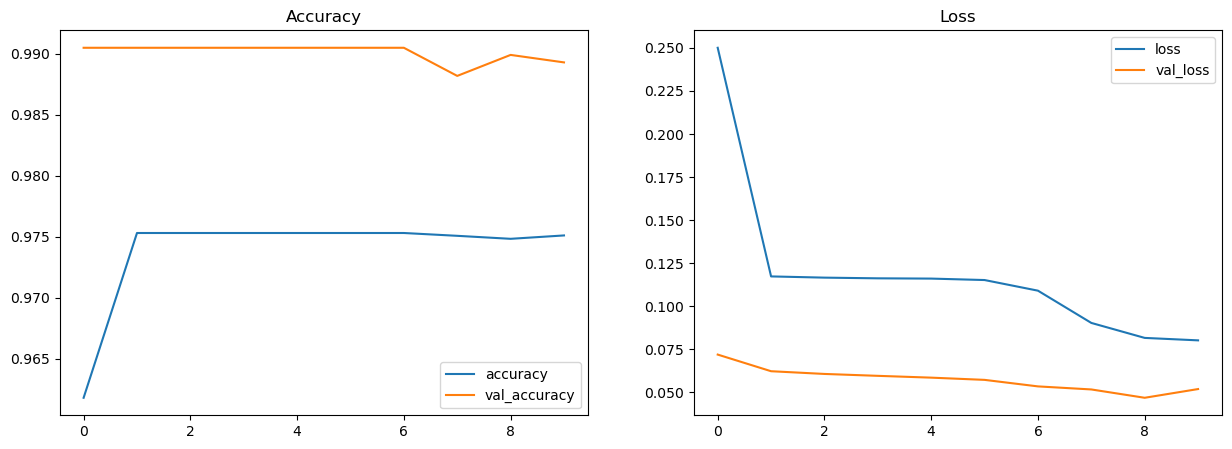

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(history.history["accuracy"])
ax2.plot(history.history["loss"])
ax1.plot(history.history['val_'+"accuracy"])
ax2.plot(history.history['val_'+"loss"])
ax1.set_title("Accuracy")
ax2.set_title("Loss")
ax1.legend(["accuracy", 'val_'+"accuracy"])
ax2.legend(["loss", 'val_'+"loss"])

In [35]:
input_txt = open("test2.txt", "r")

input_tokenized=[]
input_tokenized.append(nlp(input_txt.read()))
inp_seq = prepare_sequences(input_tokenized, max_len=MAX_LEN, vocab=vocab)
out_seq = model.predict(inp_seq, verbose=1, batch_size=1)

predict = out_seq > 0.1
        
print('Recipe: ' + str(input_tokenized[0]))
print()
ingreds_test = [t.text for t, p in zip(input_tokenized[0], predict[0]) if p]
set(ingreds_test)
ing=[]
for i in ingreds_test:
    # if i in dic_ing.keys() and i not in ing:
    if i not in ing:
        ing.append(i)
ing=str(','.join(ing))
print('Ingredients: '+ing)

# title = input('Give Title: ')
# csv.loc[len(csv)]={'title':title,'ingredients':ing,'recipe':txt}

# csv.to_csv('csv_file/file_name.csv', index=False)

1/1 [==============================] - 0s 213ms/step
Recipe: Season the steaks with garlic, paprika, salt, and pepper. Heat the olive oil in a large skillet over high heat.

Add the steaks to the skillet and cook them for 2-3 minutes on each side or until they reach your desired level of doneness. Remove them from the skillet and set them aside.

In the same skillet, melt the butter and fry the eggs to your desired level of doneness.

Add the red wine vinegar to the skillet and stir to scrape up any browned bits from the bottom of the pan. Reduce the heat to low and simmer for a minute.

Serve the steaks on a plate with fries, rice, and salad. Place a fried egg on top of each steak and drizzle the pan sauce over the top.

Ingredients: garlic,paprika,salt,pepper,olive,oil,butter,wine,rice,egg,steak


: 

In [8]:
import pickle

tf.saved_model.save(model, 'NLP/model/recipe_ing_model.h5')

with open('NLP/save/vocab.pkl', 'wb') as fp:
    pickle.dump(vocab, fp)
    
# with open('NL/save/ingred_vocab.pkl', 'wb') as fp:
#     pickle.dump(dic_ing, fp)

INFO:tensorflow:Assets written to: NLP/model/recipe_ing_model.h5/assets


INFO:tensorflow:Assets written to: NLP/model/recipe_ing_model.h5/assets


In [ ]:
# with open('NL/save/vocab.pkl', 'rb') as fp:
#         vocab = pickle.load(fp)
        
# with open('NL/save/ingred_vocab.pkl', 'rb') as fp:
#     dic_ing = pickle.load(fp)

# model = tf.saved_model.load('NL/model/recipe_ing_model.h5')

# input = open("test.txt", "r")

# input_tokenized=[]
# input_tokenized.append(nlp(input.read()))
# inp_seq = prepare_sequences(input_tokenized, max_len=MAX_LEN, vocab=vocab)
# out_seq = model(inp_seq)

# predict = out_seq > 0.05
# ingreds_test = [t.text for t, p in zip(input_tokenized[0], predict[0]) if p]
# set(ingreds_test)
# ing=[]
# for i in ingreds_test:
#     if i in dic_ing.keys() and i not in ing:
#         ing.append(i)

# print('Ingredients: ',end="")
# [print(i,end=", ") for i in ing]
# print()